In [158]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import shutil
import thor.data as data
import thor.data.dispatch as dispatch
import thor.grid as grid
import thor.track as track
import thor.option as option
import thor.visualize as visualize
import thor.attribute as attribute

notebook_name = "cpol_demo.ipynb"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
# Parent directory for saving outputs
base_local = Path.home() / "THOR_output"
start = "2005-11-13T16:00:00"
end = "2005-11-13T18:00:00"

# Create the data_options dictionary
converted_options = {"save": True, "load": False, "parent_converted": None}
cpol_options = data.aura.cpol_data_options(
    start=start, end=end, converted_options=converted_options
)
# Restrict the ERA5 data to a smaller region containing the CPOL radar
lon_range = [129, 133]
lat_range = [-14, -10]
era5_pl_options = data.era5.data_options(
    start=start, end=end, latitude_range=lat_range, longitude_range=lon_range
)
era5_sl_options = data.era5.data_options(
    start=start,
    end=end,
    data_format="single-levels",
    latitude_range=lat_range,
    longitude_range=lon_range,
)
data_options = option.consolidate_options(
    [cpol_options, era5_pl_options, era5_sl_options]
)

dispatch.check_data_options(data_options)
data.option.save_data_options(data_options, filename="cpol_era5")

grid_options = grid.create_options(name="geographic")
grid.check_options(grid_options)
grid.save_grid_options(grid_options, filename="cpol_geographic")

# Create the track_options dictionary
track_options = option.mcs(dataset="cpol")
option.save_track_options(track_options, filename="cpol_mcs")

# Create the display_options dictionary
visualize_options = {
    obj: visualize.option.runtime_options(obj, save=True, style="presentation")
    for obj in ["mcs"]
}
# visualize_options["middle_cloud"] = visualize.option.runtime_options(
#     "middle_cloud", save=True, style="presentation", figure_types=["mask"]
# )
# visualize.option.save_display_options(visualize_options, filename="runtime_mcs")
visualize_options = None

2024-09-24 13:45:10,012 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/data_options/cpol_era5.yaml
2024-09-24 13:45:10,066 - thor.grid - WARNING - Shape not specified. Will attempt to infer from input.
2024-09-24 13:45:10,067 - thor.grid - WARNING - Coordinates not specified. Will attempt to infer from input.
2024-09-24 13:45:10,070 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/grid_options/cpol_geographic.yaml
2024-09-24 13:45:10,105 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/track_options/cpol_mcs.yaml


In [177]:
output_directory = base_local / "runs/cpol_demo_geographic"
if output_directory.exists():
    shutil.rmtree(output_directory)
times = data.utils.generate_times(data_options["cpol"])
tracks = track.simultaneous_track(
    times,
    data_options,
    grid_options,
    track_options,
    visualize_options,
    output_directory=output_directory
)

2024-09-24 13:45:10,682 - thor.track - INFO - Beginning simultaneous tracking.
2024-09-24 13:45:10,765 - thor.track - INFO - Processing 2005-11-13T14:00:09.
2024-09-24 13:45:10,767 - thor.data.aura - INFO - Updating cpol dataset for 2005-11-13T14:00:09.
2024-09-24 13:45:10,768 - thor.data.aura - INFO - Converting cpol data from twp10cpolgrid150.b2.20051113.140000.nc
2024-09-24 13:45:10,820 - thor.data.aura - INFO - Creating new geographic grid with spacing 0.025 m, 0.025 m.
2024-09-24 13:45:11,471 - thor.track - INFO - Processing hierarchy level 0.
2024-09-24 13:45:11,473 - thor.track - INFO - Tracking cell.
2024-09-24 13:45:11,493 - thor.match.match - INFO - Matching cell objects.
2024-09-24 13:45:11,495 - thor.match.match - INFO - No previous mask, or no objects in previous mask.
2024-09-24 13:45:11,501 - thor.visualize.runtime - INFO - Generating runtime visualizations.
2024-09-24 13:45:11,502 - thor.track - INFO - Tracking middle_cloud.
2024-09-24 13:45:11,511 - thor.visualize.runt

In [131]:
test = attribute.utils.read_attribute_csv(output_directory / "attributes/cell/profile.csv")
test

latitude  longitude  \
time                universal_id altitude                        
2005-11-13 14:00:09 1            0.0        -12.375    131.675   
                                 500.0      -12.375    131.675   
                                 1000.0     -12.375    131.675   
                                 1500.0     -12.375    131.675   
                                 2000.0     -12.375    131.675   
...                                             ...        ...   
2005-11-13 15:50:09 13           23000.0    -12.200    131.025   
                                 23500.0    -12.200    131.025   
                                 24000.0    -12.200    131.025   
                                 24500.0    -12.200    131.025   
                                 25000.0    -12.200    131.025   

                                           relative_humidity  temperature  \
time                universal_id altitude                                   
2005-11-13 14:00:09 1            0.0                     NaN          NaN   
                                 500.0                  75.7       298.97   
                                 1000.0                 73.0       296.03   
                                 1500.0                 80.1       292.62   
                                 2000.0                 87.1       288.93   
...                                                      ...          ...   
2005-11-13 15:50:09 13           23000.0                 2.7       211.12   
                                 23500.0                 1.4       212.85   
                                 24000.0                 0.9       215.09   
                                 24500.0                 0.8       217.51   
                                 25000.0                 0.6       219.93   

                                              u    v  
time                universal_id altitude             
2005-11-13 14:00:09 1            0.0        NaN  NaN  
                                 500.0     -0.6 -2.3  
                                 1000.0    -3.4 -1.4  
                                 1500.0    -6.7  1.6  
                                 2000.0    -8.5  3.3  
...                                         ...  ...  
2005-11-13 15:50:09 13           23000.0  -23.5  3.4  
                                 23500.0  -25.4  3.8  
                                 24000.0  -24.7  3.7  
                                 24500.0  -23.1  3.3  
                                 25000.0  -21.6  2.9  

[2040 rows x 6 columns]

<Axes: xlabel='altitude'>

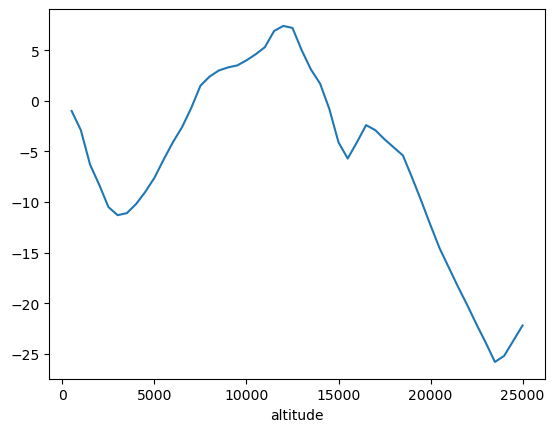

In [133]:
import numpy as np
test["u"].xs(np.datetime64("2005-11-13T14:00:09"), level="time").xs(2, level="universal_id").plot()

# Cartesian Coordinates

In [63]:
grid_options = grid.create_options(name="cartesian", regrid=False)
grid.check_options(grid_options)
grid.save_grid_options(grid_options, filename="cpol_cartesian")

2024-09-03 14:32:03,096 - thor.grid - WARNING - Shape not specified. Will attempt to infer from input.
2024-09-03 14:32:03,100 - thor.option - DEBUG - Saving options to /home/ewan/THOR_output/options/grid_options/cpol_cartesian.yaml


In [66]:
output_directory = base_local / "runs/cpol_demo_cartesian"
if output_directory.exists():
    shutil.rmtree(output_directory)
times = data.utils.generate_times(data_options["cpol"])
tracks = track.simultaneous_track(
    times,
    data_options,
    grid_options,
    track_options,
    visualize_options,
    output_directory=output_directory,
)

2024-09-03 15:04:19,440 - thor.track - INFO - Beginning simultaneous tracking.
2024-09-03 15:04:19,600 - thor.track - INFO - Processing 2005-11-13T14:00:09.
2024-09-03 15:04:19,603 - thor.data.aura - INFO - Updating cpol dataset for 2005-11-13T14:00:09.
2024-09-03 15:04:19,604 - thor.data.aura - INFO - Converting cpol data from twp10cpolgrid150.b2.20051113.140000.nc
2024-09-03 15:04:19,830 - thor.track - INFO - Processing hierarchy level 0.
2024-09-03 15:04:19,831 - thor.track - INFO - Tracking cell.
2024-09-03 15:04:19,853 - thor.match.match - INFO - Matching cell objects.
2024-09-03 15:04:19,855 - thor.match.match - INFO - No previous mask, or no objects in previous mask.
2024-09-03 15:04:19,862 - thor.visualize.runtime - INFO - Generating runtime visualizations.
2024-09-03 15:04:19,863 - thor.attribute.attribute - INFO - Recording object attributes.
2024-09-03 15:04:19,865 - thor.track - INFO - Tracking middle_cloud.
2024-09-03 15:04:19,875 - thor.visualize.runtime - INFO - Generati